### Hexapod Forward Kinematics Linear Regression ###

* Data generated by the straight solution of inverse kinematics can be used to 
  build a simple linear regression model for each parameter (x,y,z,rx,ry,rz), and these models even though
  don't provide an acceptable solution, they can be used as an initial guess for the Newton-Raphson method 
  applied to the Forward Kinematics system of non-linear equations which will guarantee the right solution
  (avoiding local minimuns problems and possible not expected results) in few iterations.

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output

### Inverse Kinematics ###

In [ ]:
import Hexapod_Functions
from Hexapod_Functions import Rotation_XYZ, Hexapod_Constructive_Vectors

In [44]:
a, b = Hexapod_Constructive_Vectors()

a1 = a[0]; a2 = a[1]; a3 = a[2];
a4 = a[3]; a5 = a[4]; a6 = a[5];

b1 = b[0]; b2 = b[1]; b3 = b[2] 
b4 = b[3]; b5 = b[4]; b6 = b[5]

In [45]:
def Inverse_Kin(x,y,z,rx,ry,rz):
    
    # Vectorial Equation to Calculate Target Leg length:
    l1 = np.linalg.norm(np.array((x,y,z)) + Rotation_XYZ(rx, ry, rz).dot(b1) - a1)
    l2 = np.linalg.norm(np.array((x,y,z)) + Rotation_XYZ(rx, ry, rz).dot(b2) - a2)
    l3 = np.linalg.norm(np.array((x,y,z)) + Rotation_XYZ(rx, ry, rz).dot(b3) - a3)
    l4 = np.linalg.norm(np.array((x,y,z)) + Rotation_XYZ(rx, ry, rz).dot(b4) - a4)
    l5 = np.linalg.norm(np.array((x,y,z)) + Rotation_XYZ(rx, ry, rz).dot(b5) - a5)
    l6 = np.linalg.norm(np.array((x,y,z)) + Rotation_XYZ(rx, ry, rz).dot(b6) - a6)
    
    return np.array([x,y,z,rx,ry,rz,l1,l2,l3,l4,l5,l6])

### Data Set Generation from Iinverse Kinematics ###

In [167]:
data = Inverse_Kin(0,0,108,0,0,0)
print(data)

[  0.           0.         108.           0.           0.
   0.         113.09885969 113.09885969 113.09885969 113.09885969
 113.09885969 113.09885969]


In [168]:
# Inverse Kinematics Motion Range Sweep to Generate Training Data:
cnt = 0

for x in range(-20, 20, 4):
    for y in range(-20, 20, 4):
        for z in range(98, 118, 2):
            for rx in range(-15, 15, 3):
                for ry in range(-15, 15, 3):
                    for rz in range(-15, 15, 3):
                        cnt += 1
                        newrow = Inverse_Kin(x,y,z,rx,ry,rz)
                        data = np.vstack([data, newrow])
                        clear_output(wait = True)
                        print(cnt, '/1000000')

1000000 /1000000


In [348]:
print(data.shape)

(1000001, 12)


In [170]:
# Saving Data Set:
np.savetxt('data_1M.csv', data, delimiter = ' ')

In [171]:
data_df = pd.read_csv('data_1M.csv', delimiter = ' ')
data_df = pd.DataFrame(data_df)
data_df.columns = ['X', 'Y', 'Z', 'RX', 'RY', 'RZ', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6']
data_df.head()
data_df.tail()

,X,Y,Z,RX,RY,RZ,l1,l2,l3,l4,l5,l6
999995,16.0,16.0,116.0,12.0,12.0,0.0,124.159441,131.504387,137.690631,126.085811,107.407505,111.728202
999996,16.0,16.0,116.0,12.0,12.0,3.0,123.603281,131.434755,137.125185,126.538195,107.490771,112.570934
999997,16.0,16.0,116.0,12.0,12.0,6.0,123.107279,131.434935,136.651989,127.095461,107.672868,113.479050
999998,16.0,16.0,116.0,12.0,12.0,9.0,122.673534,131.504925,136.273308,127.754719,107.952800,114.448536
999999,16.0,16.0,116.0,12.0,12.0,12.0,122.303902,131.644423,135.990973,128.512609,108.329044,115.475224


In [173]:
# Data Input and Output Separation:

# Input
Legs_data = data[:,6:12]

# Variables to be predicted:
X_data = data[:,0]
Y_data = data[:,1]
Z_data = data[:,2]
RX_data = data[:,3]
RY_data = data[:,4]
RZ_data = data[:,5]

print(Legs_data.shape)
print(X_data)

(1000001, 6)
[  0. -20. -20. ...  16.  16.  16.]


### Linear Regression and Analysis ###

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

In [349]:
def Guess_Regression(X,Y,graph_title_string):
    
    # As we want something close to over-fitting inside the range, let's use 0.1% as test size:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.001, random_state = 1)
    reg = LinearRegression().fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mse)

    # R2 and adjust :
    k = X_test.shape[1]
    n = len(X_test)
    r2 = r2_score(y_test, y_predict)
    adj_r2 = 1 - (1-r2) * (n-1) / (n-k-1) 
    
    # Use 40 samples to plot:
    y_predict = y_predict[:40]
    y_test = y_test[:40]
    
    plt.plot(y_predict, '--',color = 'blue')
    plt.plot(y_test, color = 'red')
    plt.ylabel('Result')
    plt.xlabel('Samples')
    plt.title(graph_title_string)
    plt.legend(['Prediction', 'True Values'])
    plt.show()
    
    print('MODEL METRICS:')
    print('MAE', mae)
    print('MSE', mse)
    print('RMSE', rmse)
    print('R2', r2)
    print('R2 ADJ', adj_r2)
    
    return reg

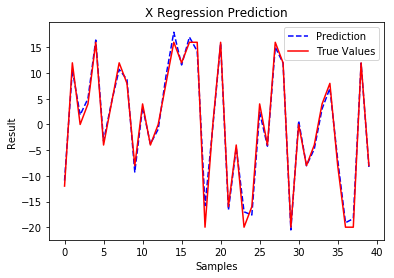

MODEL METRICS:
MAE 1.0199205801393991
MSE 1.7578828782651
RMSE 1.3258517557649874
R2 0.986740439795253
R2 ADJ 0.986660402208504


Coefs: [ 1.88615277 -1.87370475 -0.20802189  1.69585106 -1.68264555  0.16406638] 2.020663338799261

 Equation: 
 X = l1*(-0.7331956425372629) + l2*(0.7549284963119954) + l3*(0.46037815100044177) + l4*(-0.3090325816698745) + l5*(0.3409091024837853) + l6*(-0.5123710430740838) + (2.020663338799261)


In [452]:
X_reg = Guess_Regression(Legs_data, X_data,'X Regression Prediction')
print('\n')
print('Coefs:', X_reg.coef_, X_reg.intercept_)
coef = RY_reg.coef_
func_string = 'X = ' + 'l1*('+ str(coef[0]) + ') + l2*('+ str(coef[1]) + ') + l3*('+ str(coef[2]) + ') + l4*(' + str(coef[3]) + ') + l5*('+ str(coef[4]) + ') + l6*('+ str(coef[5]) + ') + (' + str(X_reg.intercept_) + ')'        
print('\n', 'Equation:', '\n', func_string)

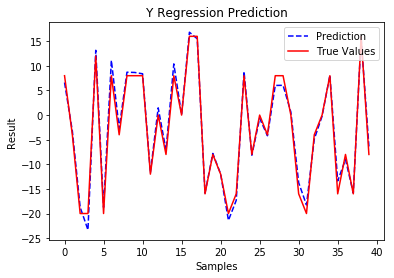

MODEL METRICS:
MAE 0.9037202868207531
MSE 1.3350588251730031
RMSE 1.1554474566906983
R2 0.9898434806394247
R2 ADJ 0.9897821736815138


Coefs: [-0.89908649 -0.83392389  2.00398529 -1.15060835 -1.15333133  2.01541626] 1.970295534382284

 Equation: 
 Y = l1*(-0.7331956425372629) + l2*(0.7549284963119954) + l3*(0.46037815100044177) + l4*(-0.3090325816698745) + l5*(0.3409091024837853) + l6*(-0.5123710430740838) + (1.970295534382284)


In [453]:
Y_reg = Guess_Regression(Legs_data, Y_data, 'Y Regression Prediction')
print('\n')
print('Coefs:', Y_reg.coef_, Y_reg.intercept_)
coef = RY_reg.coef_
func_string = 'Y = ' + 'l1*('+ str(coef[0]) + ') + l2*('+ str(coef[1]) + ') + l3*('+ str(coef[2]) + ') + l4*(' + str(coef[3]) + ') + l5*('+ str(coef[4]) + ') + l6*('+ str(coef[5]) + ') + (' + str(Y_reg.intercept_) + ')'
print('\n', 'Equation:', '\n', func_string)

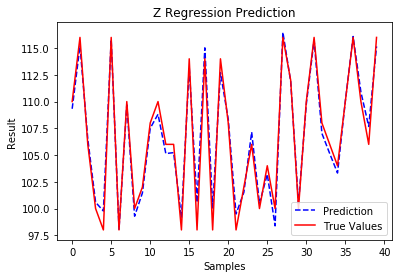

MODEL METRICS:
MAE 0.673640352202477
MSE 0.6933198668433721
RMSE 0.8326583133815287
R2 0.9797143132156734
R2 ADJ 0.9795918644020859


Coefs: [0.16702293 0.14834709 0.19350662 0.19314126 0.10334412 0.23535549] -11.403196732334223

 Equation: 
 Z = l1*(-0.7331956425372629) + l2*(0.7549284963119954) + l3*(0.46037815100044177) + l4*(-0.3090325816698745) + l5*(0.3409091024837853) + l6*(-0.5123710430740838) + (-11.403196732334223)


In [454]:
Z_reg = Guess_Regression(Legs_data, Z_data, 'Z Regression Prediction')
print('\n')
print('Coefs:', Z_reg.coef_, Z_reg.intercept_)
coef = RY_reg.coef_
func_string = 'Z = ' + 'l1*('+ str(coef[0]) + ') + l2*('+ str(coef[1]) + ') + l3*('+ str(coef[2]) + ') + l4*(' + str(coef[3]) + ') + l5*('+ str(coef[4]) + ') + l6*('+ str(coef[5]) + ') + (' + str(Z_reg.intercept_) + ')'
print('\n', 'Equation:', '\n', func_string)

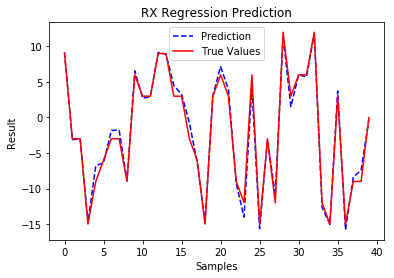

MODEL METRICS:
MAE 0.6678505484237344
MSE 0.7825081253151323
RMSE 0.8845948933354365
R2 0.9888388002671562
R2 ADJ 0.9887714288401974


Coefs: [ 0.0855275   0.1056877   0.63826859 -0.75089236 -0.67630701  0.59894329] -0.17838394322573192

 Equation: 
 RX = l1*(0.0855274976452736) + l2*(0.10568769547963643) + l3*(0.6382685929692925) + l4*(-0.7508923597754653) + l5*(-0.6763070069365704) + l6*(0.5989432877210956) + (-0.17838394322573192)


In [455]:
RX_reg = Guess_Regression(Legs_data, RX_data, 'RX Regression Prediction')
print('\n')
print('Coefs:', RX_reg.coef_, RX_reg.intercept_)
coef = RX_reg.coef_
func_string = 'RX = ' + 'l1*('+ str(coef[0]) + ') + l2*('+ str(coef[1]) + ') + l3*('+ str(coef[2]) + ') + l4*(' + str(coef[3]) + ') + l5*('+ str(coef[4]) + ') + l6*('+ str(coef[5]) + ') + (' + str(RX_reg.intercept_) + ')'
print('\n', 'Equation:', '\n', func_string)

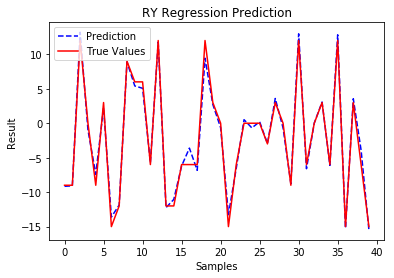

MODEL METRICS:
MAE 0.6399655168096093
MSE 0.7146208476443922
RMSE 0.8453524990466357
R2 0.9905634515944088
R2 ADJ 0.9905064905376346


Coefs: [-0.73319564  0.7549285   0.46037815 -0.30903258  0.3409091  -0.51237104] -0.23177542444635946

 Equation: 
 RY = l1*(-0.7331956425372629) + l2*(0.7549284963119954) + l3*(0.46037815100044177) + l4*(-0.3090325816698745) + l5*(0.3409091024837853) + l6*(-0.5123710430740838) + (-0.23177542444635946)


In [456]:
RY_reg = Guess_Regression(Legs_data, RY_data, 'RY Regression Prediction')
print('\n')
print('Coefs:', RY_reg.coef_, RY_reg.intercept_)
coef = RY_reg.coef_
func_string = 'RY = ' + 'l1*('+ str(coef[0]) + ') + l2*('+ str(coef[1]) + ') + l3*('+ str(coef[2]) + ') + l4*(' + str(coef[3]) + ') + l5*('+ str(coef[4]) + ') + l6*('+ str(coef[5]) + ') + (' + str(RY_reg.intercept_) + ')'
print('\n', 'Equation:', '\n', func_string)

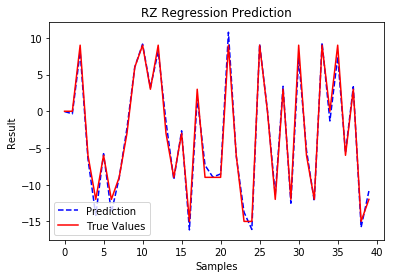

MODEL METRICS:
MAE 0.7425442598494514
MSE 0.945867681502688
RMSE 0.9725572895735696
R2 0.9869137494590771
R2 ADJ 0.9868347580071197


Coefs: [-1.2112116   1.19507677 -1.20030871  1.20522326 -1.2194197   1.21720847] 1.5048351765786454

 Equation: 
 RZ = l1*(-1.211211603246219) + l2*(1.1950767670145093) + l3*(-1.2003087117098172) + l4*(1.205223261071965) + l5*(-1.2194196972251166) + l6*(1.2172084699304395) + (1.5048351765786454)


In [457]:
RZ_reg = Guess_Regression(Legs_data, RZ_data, 'RZ Regression Prediction')
print('\n')
print('Coefs:', RZ_reg.coef_, RZ_reg.intercept_)
coef = RZ_reg.coef_
func_string = 'RZ = ' + 'l1*('+ str(coef[0]) + ') + l2*('+ str(coef[1]) + ') + l3*('+ str(coef[2]) + ') + l4*(' + str(coef[3]) + ') + l5*('+ str(coef[4]) + ') + l6*('+ str(coef[5]) + ') + (' + str(RZ_reg.intercept_) + ')'
print('\n', 'Equation:', '\n', func_string)

In [ ]:
# Final Equations:

X = l1*(-0.7331956425372629) + l2*(0.7549284963119954) + l3*(0.46037815100044177) + l4*(-0.3090325816698745) + l5*(0.3409091024837853) + l6*(-0.5123710430740838) + (2.020663338799261)
Y = l1*(-0.7331956425372629) + l2*(0.7549284963119954) + l3*(0.46037815100044177) + l4*(-0.3090325816698745) + l5*(0.3409091024837853) + l6*(-0.5123710430740838) + (1.970295534382284)
Z = l1*(-0.7331956425372629) + l2*(0.7549284963119954) + l3*(0.46037815100044177) + l4*(-0.3090325816698745) + l5*(0.3409091024837853) + l6*(-0.5123710430740838) + (-11.403196732334223)
RX = l1*(0.0855274976452736) + l2*(0.10568769547963643) + l3*(0.6382685929692925) + l4*(-0.7508923597754653) + l5*(-0.6763070069365704) + l6*(0.5989432877210956) + (-0.17838394322573192)
RY = l1*(-0.7331956425372629) + l2*(0.7549284963119954) + l3*(0.46037815100044177) + l4*(-0.3090325816698745) + l5*(0.3409091024837853) + l6*(-0.5123710430740838) + (-0.23177542444635946)
RZ = l1*(-1.211211603246219) + l2*(1.1950767670145093) + l3*(-1.2003087117098172) + l4*(1.205223261071965) + l5*(-1.2194196972251166) + l6*(1.2172084699304395) + (1.5048351765786454)

### Models Testings ###

In [364]:
Quick_Test = Inverse_Kin(-3,5,97,4.4,-6,3.24)
print(Quick_Test)

[ -3.           5.          97.           4.4         -6.
   3.24       106.20107879 103.148926    97.3537394   97.39418554
 103.75299291 109.796138  ]


In [365]:
print(X_reg.predict([Quick_Test[6:12]]))
print(Y_reg.predict([Quick_Test[6:12]]))
print(Z_reg.predict([Quick_Test[6:12]]))
print(RX_reg.predict([Quick_Test[6:12]]))
print(RY_reg.predict([Quick_Test[6:12]]))
print(RZ_reg.predict([Quick_Test[6:12]]))

[-2.58984371]
[5.12422955]
[95.84947441]
[4.40436909]
[-6.39234414]
[3.7972836]


In [443]:
def Test(N_times):

    error = np.zeros([1,6], dtype = np.float64)

    for i in range(N_times):
        x = random.uniform(-20.0, 20.0)
        y = random.uniform(-20.0, 20.0)
        z = random.uniform(98.0, 118.0)

        rx = random.uniform(-15.0, 15.0)
        ry = random.uniform(-15.0, 15.0)
        rz = random.uniform(-15.0, 15.0)

        True_Values = np.array([[x], [y], [z], [rx], [ry], [rz]], dtype=np.float64)
        Ls = Inverse_Kin(x,y,z,rx,ry,rz)
        Ls = Ls[6:12]
        Predicted_Values = np.array([X_reg.predict([Ls]), Y_reg.predict([Ls]), Z_reg.predict([Ls]),
                                    RX_reg.predict([Ls]), RY_reg.predict([Ls]), RZ_reg.predict([Ls])])
        
        e = (np.absolute(True_Values - Predicted_Values)).T
        error = np.vstack([error, e])
        
        clear_output(wait=True)
        print(i+1,'/',N_times)
        
    max_error_location = np.where(error == np.max(error))
    location_dict = {0:'X', 1:'Y', 2:'Z', 3:'RX', 4:'RY', 5:'RZ'}
    print('Max Error among the tests: ', np.max(error))
    print('Max Error happened in variable:', location_dict[np.max(max_error_location[1])])
    
    pass

In [445]:
# Testing Models 100000 times:
Test(100000)

100000 / 100000
Max Error among the tests:  6.462842758387641
Max Error happened in variable: Y
